# Practical session n°5:

##Part I: Quantile Regression with Neural networks.

* Adapted Cost Function
* Two examples with FCN
* A simultaneous quantile regression

##Part II: Sampling with GANs.

* Basic Principle and First Training
* Limitations
* A Wasserstein GAN

Duration: 4 hours

### Partie I: quantile regression   

In this part, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [ ]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 278 (delta 105), reused 130 (delta 84), pack-reused 117
Receiving objects: 100% (278/278), 14.79 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (118/118), done.


**Exercise 1**: an adapted cost function

As seen in the previous practical session n°3, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

In [ ]:
os.chdir('ml-student/TP3/')
from utile import gen_proba

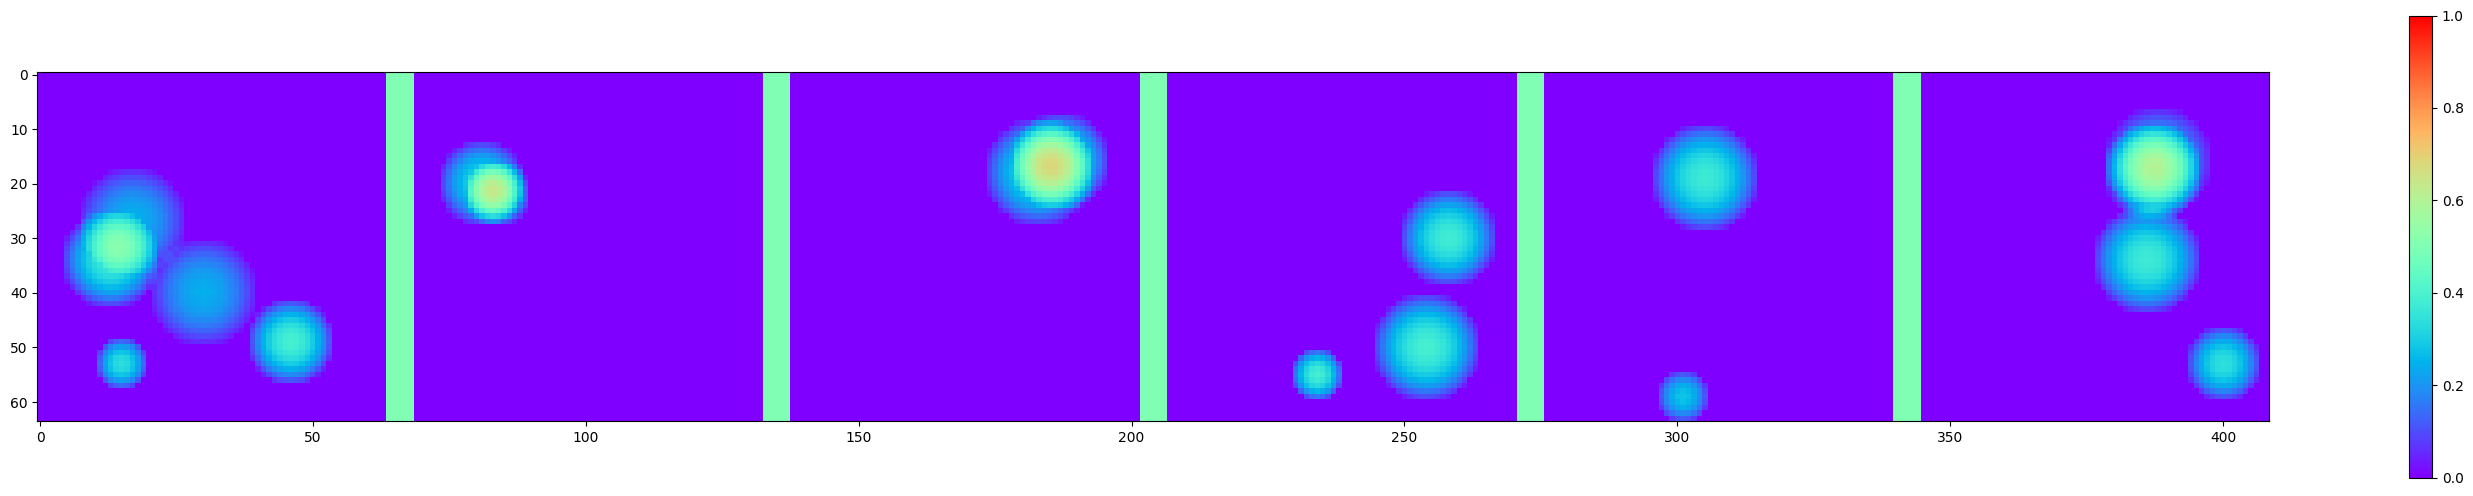

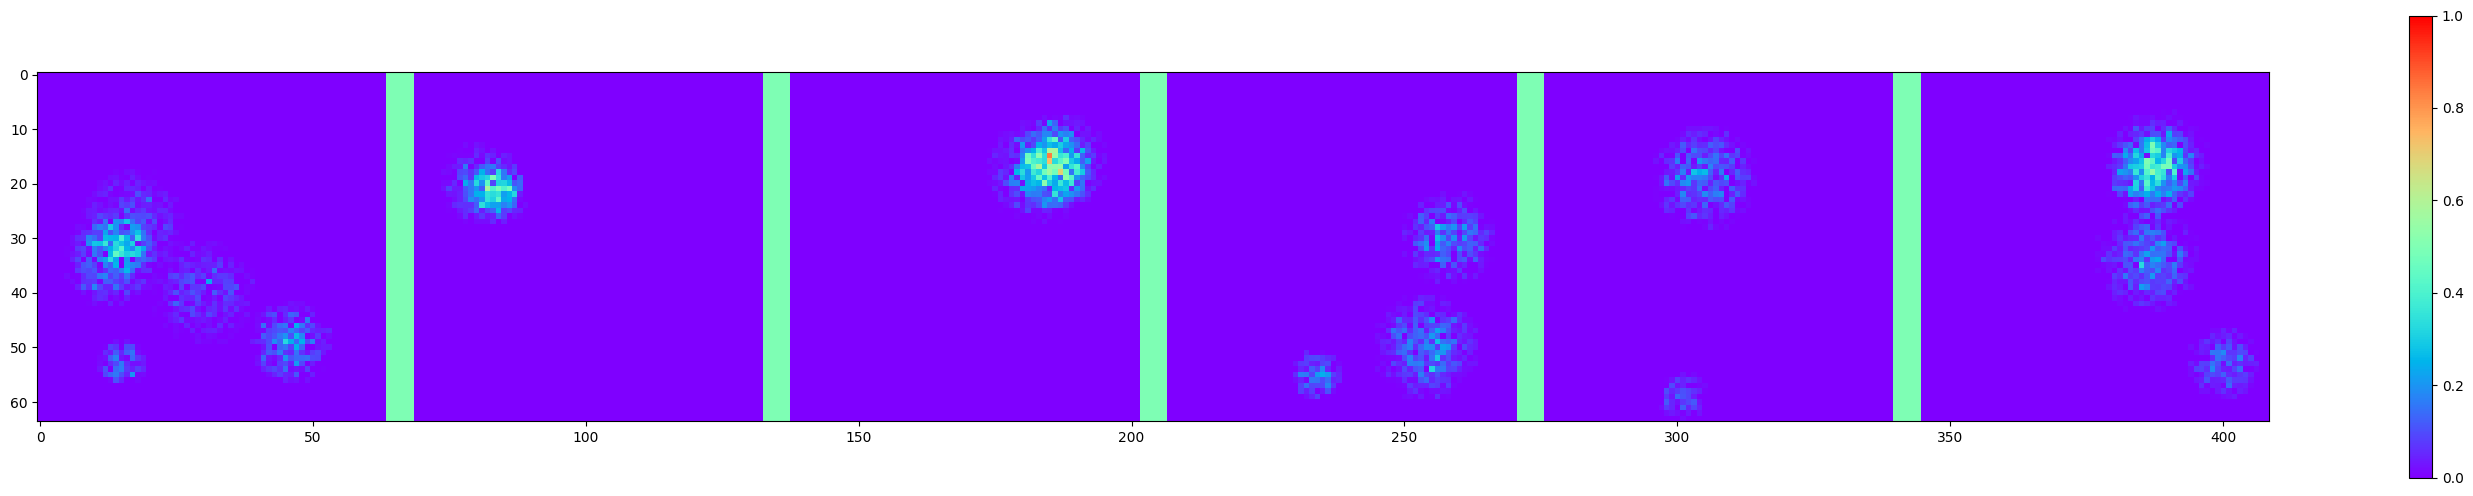

In [ ]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y)$$
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

One can show (see accompanying exercise sheet for the practical session) that the value of $z$ that minimizes the expectation $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , z) ]$ is the $t$-th quantile of the distribution of $y_{i,j}$.

In the context where the value $y_{i,j}$  depends on the image $x$, minimizing $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , f^\theta_{i,j}(x))]$ will therefore constrain the network $f^\theta$ to provide the $t$-th quantile of $p(y_{i,j} | x)$.

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles.

In [ ]:
t = 0.1

def rho(u,t):
        loss = t*u.clamp(min=0.) + (t-1)*u.clamp(max=0.)
        loss = loss.mean()
        return loss

def criterion(output, target):
  return rhot(target-output, t)

**Q3** Train a U-Net to estimate the ninth decile.

In [ ]:
def criterion(output, target):
  return rhot(target-output,0.9)

In [ ]:
fcn = UNet(1,1,8).cuda()
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):

        # Sampling (X,Y)
        input,target = gen_proba(batchsize)

        input = input.cuda()
        target = target.cuda()

        # Forward
        optimizer.zero_grad()
        output = fcn(input)

        # Loss
        loss = criterion(output,target)

        # Gradients
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.0012510233
Epoch 1
epoch loss : 

0.0011985454
Epoch 2
epoch loss : 

0.001202923
Epoch 3
epoch loss : 

0.00119212
Epoch 4
epoch loss : 

0.0011871037
Epoch 5
epoch loss : 

0.0011891146
Epoch 6
epoch loss : 

0.0011719073
Epoch 7
epoch loss : 

0.0011589332
Epoch 8
epoch loss : 

0.0011786158
Epoch 9
epoch loss : 

0.0011816272
Epoch 10
epoch loss : 

0.0011747063
Epoch 11
epoch loss : 

0.0011739577
Epoch 12
epoch loss : 

0.0011613105
Epoch 13
epoch loss : 

0.0011722668
Epoch 14
epoch loss : 

0.001151494
Epoch 15
epoch loss : 

0.0011641312
Epoch 16
epoch loss : 

0.0011573369
Epoch 17
epoch loss : 

0.001175082
Epoch 18
epoch loss : 

0.0011774864
Epoch 19
epoch loss : 

0.0011738339
Epoch 20
epoch loss : 

0.001165072
Epoch 21
epoch loss : 

0.0011635852
Epoch 22
epoch loss : 

0.0011971691
Epoch 23
epoch loss : 

0.001181177
Epoch 24
epoch loss : 

0.0011638561
Epoch 25
epoch loss : 

0.0011522289
Epoch 26
epoch loss : 

0.0011680614
Epoch 27
epoch los

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

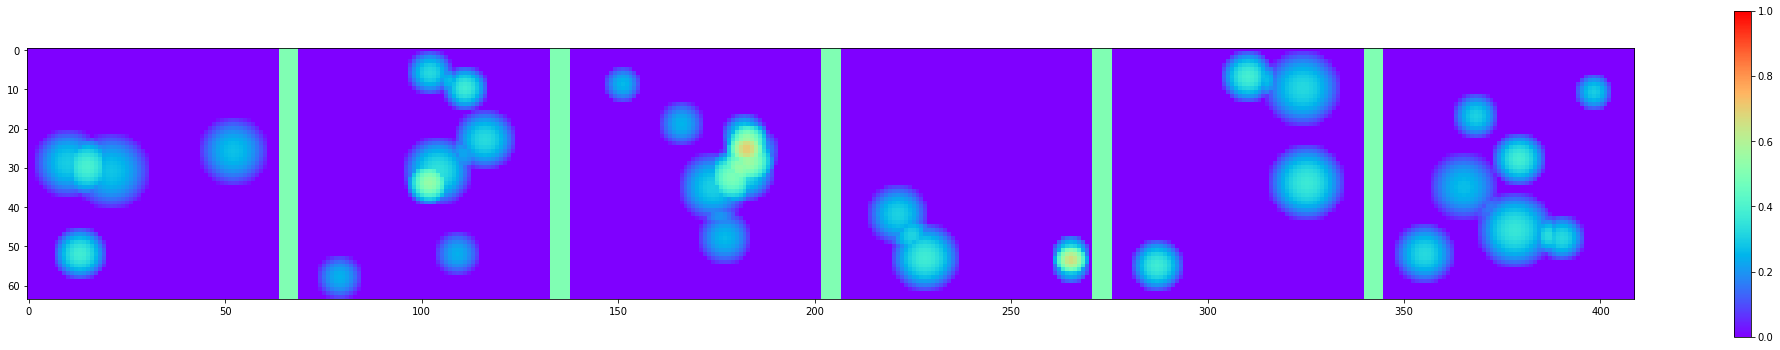

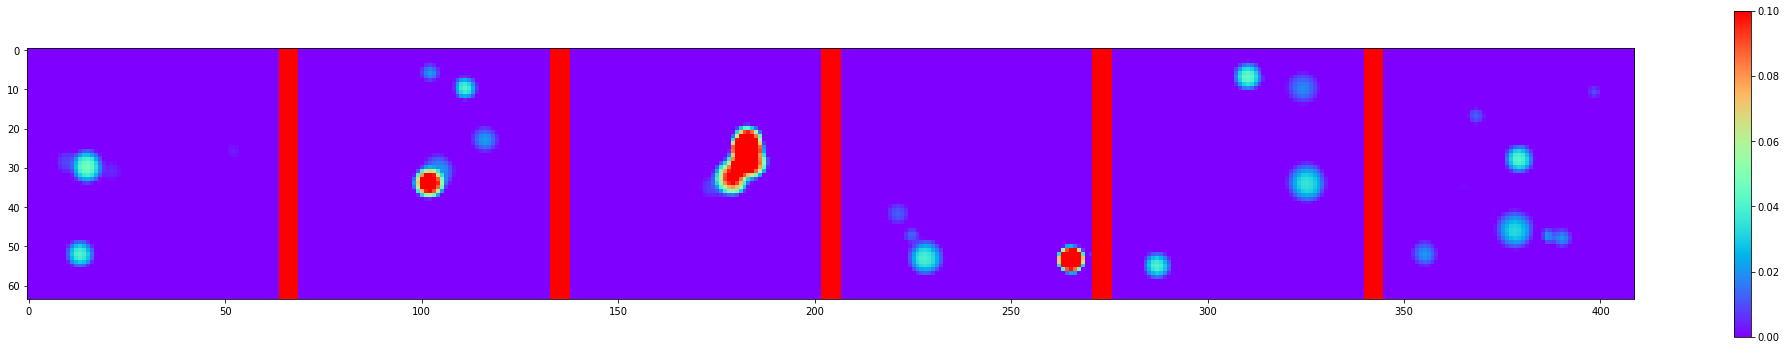

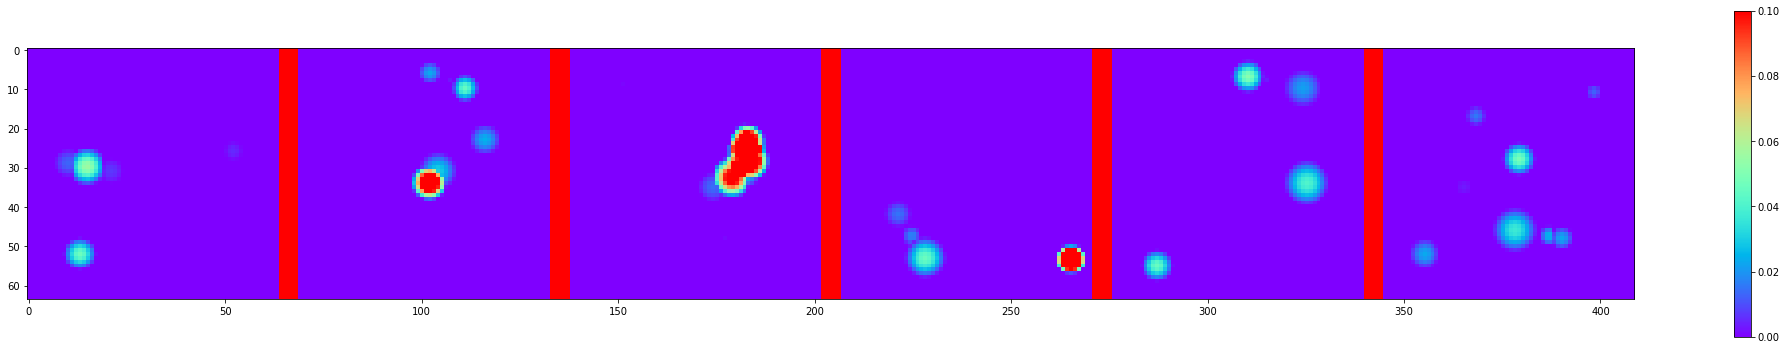

/content/drive/MyDrive/TP_2022_corr/utile.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


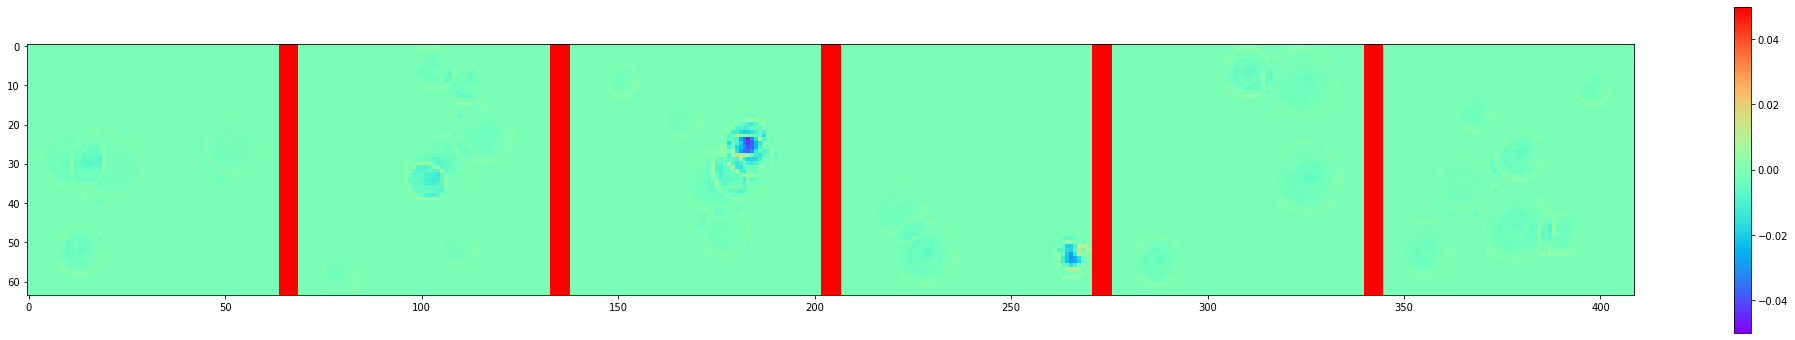

In [ ]:
# viz:

fcn.eval()
input, target = gen_proba(6)
output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) #Entrées: première ligne
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=0.1) #Sorties: deuxième ligne

# true quantile
m = torch.distributions.normal.Normal(input**2, 0.2*input+0.000001, validate_args=None)
quantiles = m.icdf(0*input + 0.1)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) #Premier décile (ground truth)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - quantiles, 6, fig2, k=0, min_scale=-0.05,max_scale=0.05) #sorties - ground truth


**Exercise 2**: a trickier dependence

Let's now work with the *gen_proba_2* function. Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

In [ ]:
def gen_proba_2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  m = torch.normal(2, 2. + target2)
  input = target1 + target2
  target =   m
  return  input, target


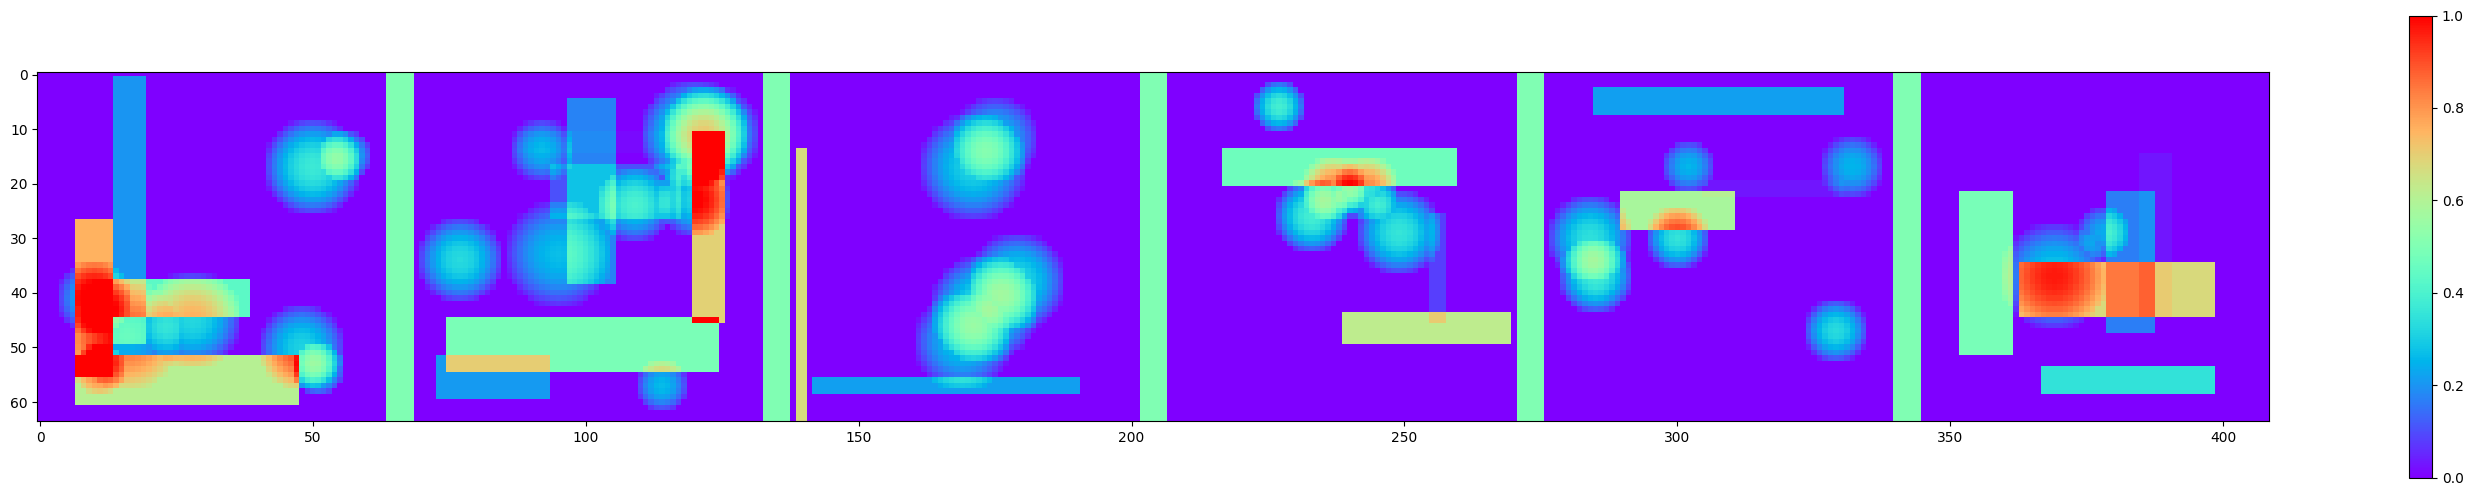

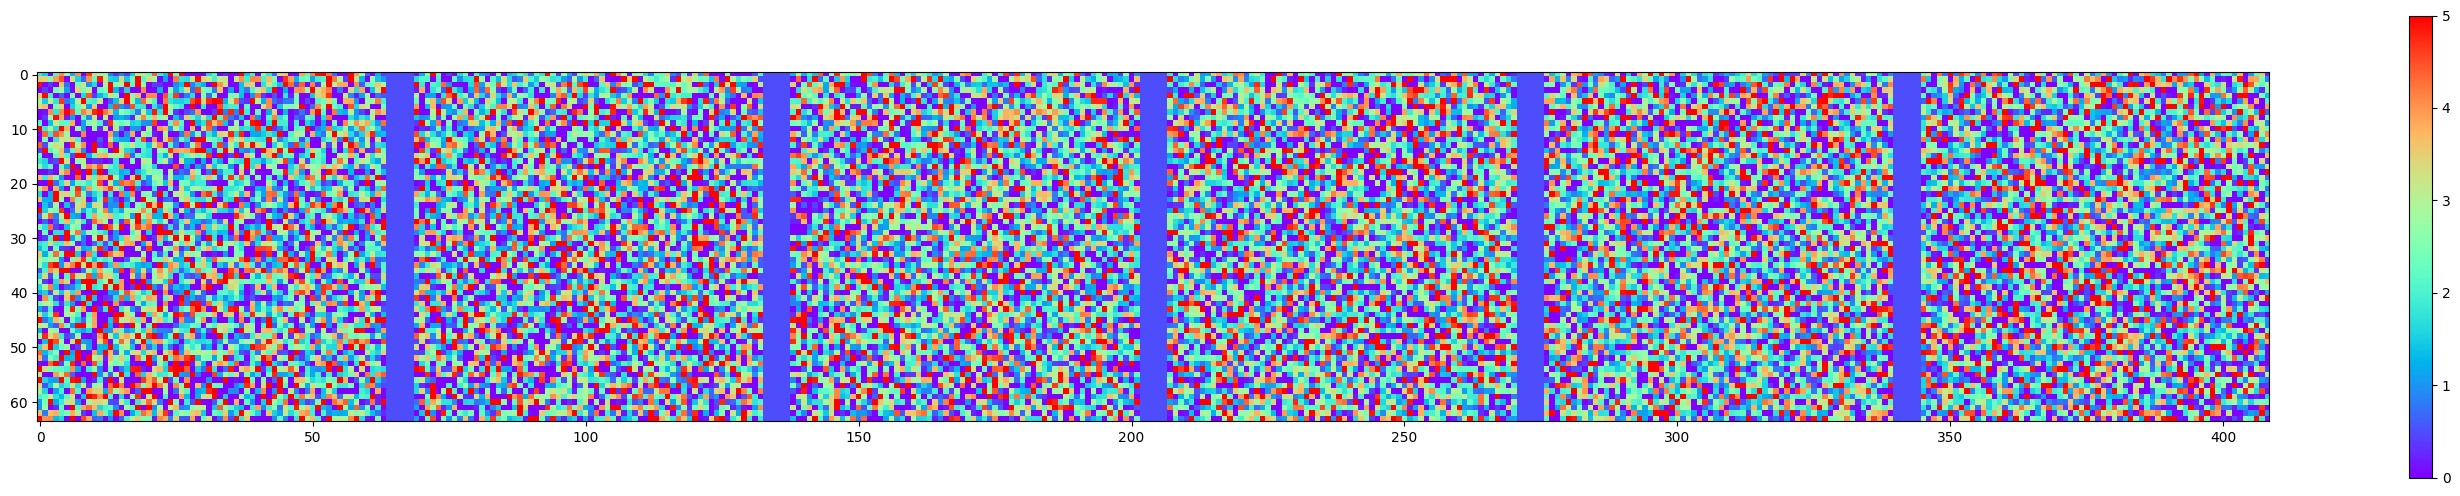

In [ ]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [ ]:
def criterion(output, target):
  return rhot(target-output,0.1)  #on vise le premier décile

nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        #Echantillonnage de (X,Y)
        input,target = gen_proba_exo2(batchsize)

        input = input.cuda()
        target = target.cuda()

        # Estimation (passe avant)
        optimizer.zero_grad()
        output = fcn(input)

        # Fonction de coût
        loss = criterion(output,target)

        # Gradients
        loss.backward()

        # MAJ des poids
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.37048
Epoch 1
epoch loss : 

0.3660737
Epoch 2
epoch loss : 

0.36602557
Epoch 3
epoch loss : 

0.3657923
Epoch 4
epoch loss : 

0.3657329
Epoch 5
epoch loss : 

0.36596036
Epoch 6
epoch loss : 

0.36558494
Epoch 7
epoch loss : 

0.36558098
Epoch 8
epoch loss : 

0.36588272
Epoch 9
epoch loss : 

0.36589256
Epoch 10
epoch loss : 

0.36588517
Epoch 11
epoch loss : 

0.36614066
Epoch 12
epoch loss : 

0.36557543
Epoch 13
epoch loss : 

0.36600387
Epoch 14
epoch loss : 

0.36590508
Epoch 15
epoch loss : 

0.36600715
Epoch 16
epoch loss : 

0.36588505
Epoch 17
epoch loss : 

0.36564142
Epoch 18
epoch loss : 

0.3659638
Epoch 19
epoch loss : 

0.3658122
Epoch 20
epoch loss : 

0.3655183
Epoch 21
epoch loss : 

0.3655673
Epoch 22
epoch loss : 

0.36544868
Epoch 23
epoch loss : 

0.3659077
Epoch 24
epoch loss : 

0.3659131
Epoch 25
epoch loss : 

0.3655021
Epoch 26
epoch loss : 

0.36573875
Epoch 27
epoch loss : 

0.3659142
Epoch 28
epoch loss : 

0.36574927
Epoch 29


KeyboardInterrupt: ignored

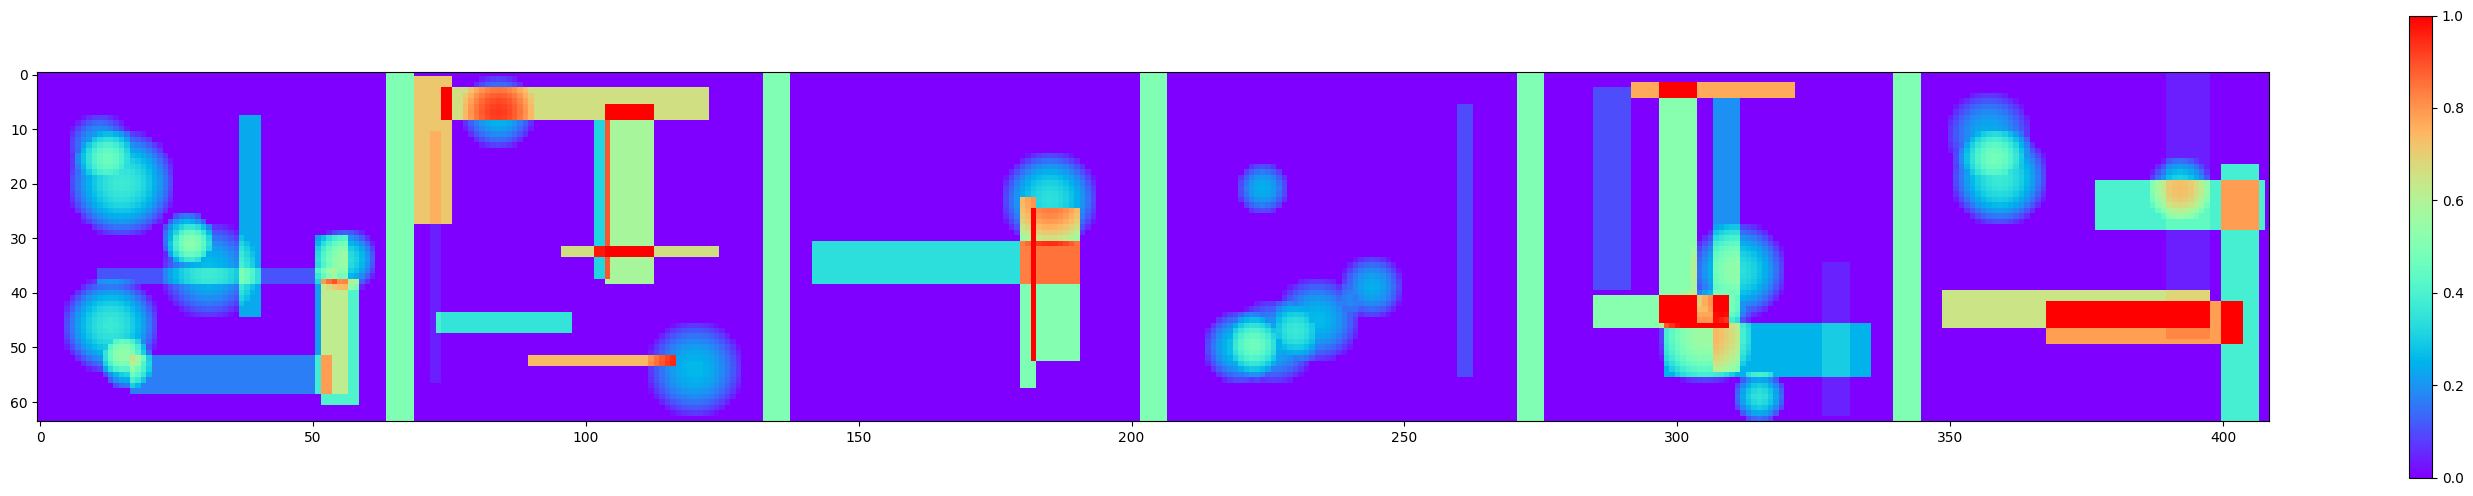

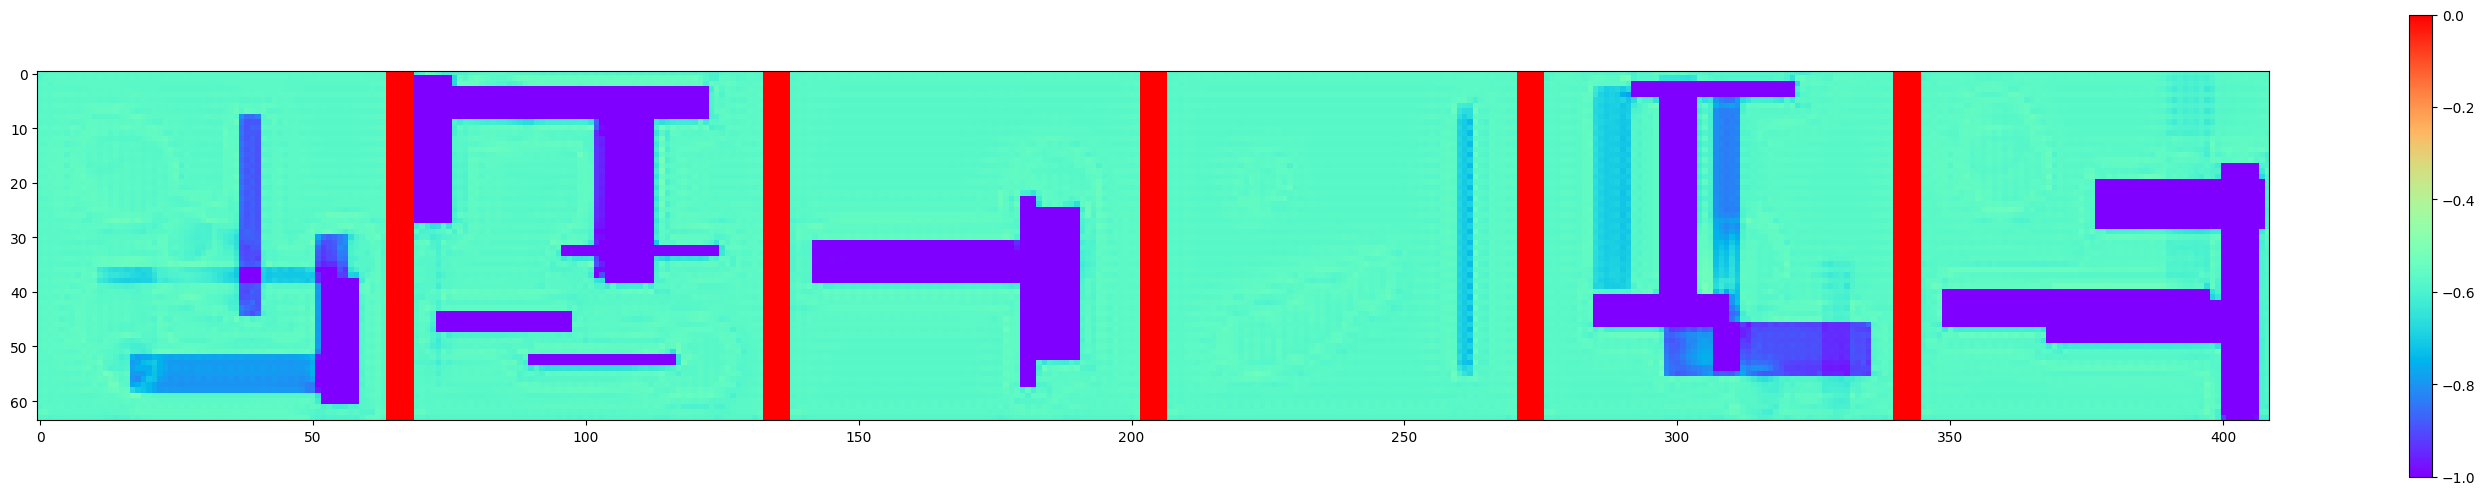

In [ ]:
#visualisation:

fcn.eval()

input, target = gen_proba_exo2(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=-1,max_scale=0)

**Q2** Do we have a dependance ? Is it still a pixel-wise dependence (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)?

Clairement non, puisque le quantile ne dépend que de la présence de rectangles. Les disques n'on pas d'influence sur la distribution. C'est modélisable par:

$$Y_{i,j} \sim \mathcal{N}(\mu([\xi(X)]_{i,j}), \sigma([\xi(X)]_{i,j})) $$

où la valeur de $[\xi(X)]_{i,j}$ donne la dépendance au contexte (disque ou rectangle).

**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


In [ ]:
def dot(t, M):
	return (M * t.view((1,t.shape[0],1,1)) ).sum(dim=1)

**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output
        loss_by_pix = dot(self.t , d.clamp(min =0)) \
                      + dot( self.t - 1 , d.clamp(max =0))
        loss = torch.mean(loss_by_pix)

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.

In [ ]:
n = 100
fcn = UNet(1,n-1,32).cuda()
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

criterion = QuantileLoss(n)

In [ ]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        input,target = gen(batchsize)

        input = input.cuda()
        target = target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)



Epoch 0
epoch loss : 

0.25705585
Epoch 1
epoch loss : 

0.23656675
Epoch 2
epoch loss : 

0.24364215
Epoch 3
epoch loss : 

0.24131025
Epoch 4
epoch loss : 

0.23752041
Epoch 5
epoch loss : 

0.23442705
Epoch 6
epoch loss : 

0.23404953
Epoch 7
epoch loss : 

0.24030985
Epoch 8
epoch loss : 

0.23313794
Epoch 9
epoch loss : 

0.23135445
Epoch 10
epoch loss : 

0.2307611
Epoch 11
epoch loss : 

0.23157929
Epoch 12
epoch loss : 

0.22984016
Epoch 13
epoch loss : 

0.23196198
Epoch 14
epoch loss : 

0.23246315
Epoch 15
epoch loss : 

0.2313808
Epoch 16
epoch loss : 

0.23184668
Epoch 17
epoch loss : 

0.23032068
Epoch 18
epoch loss : 

0.2298012
Epoch 19
epoch loss : 

0.23709115


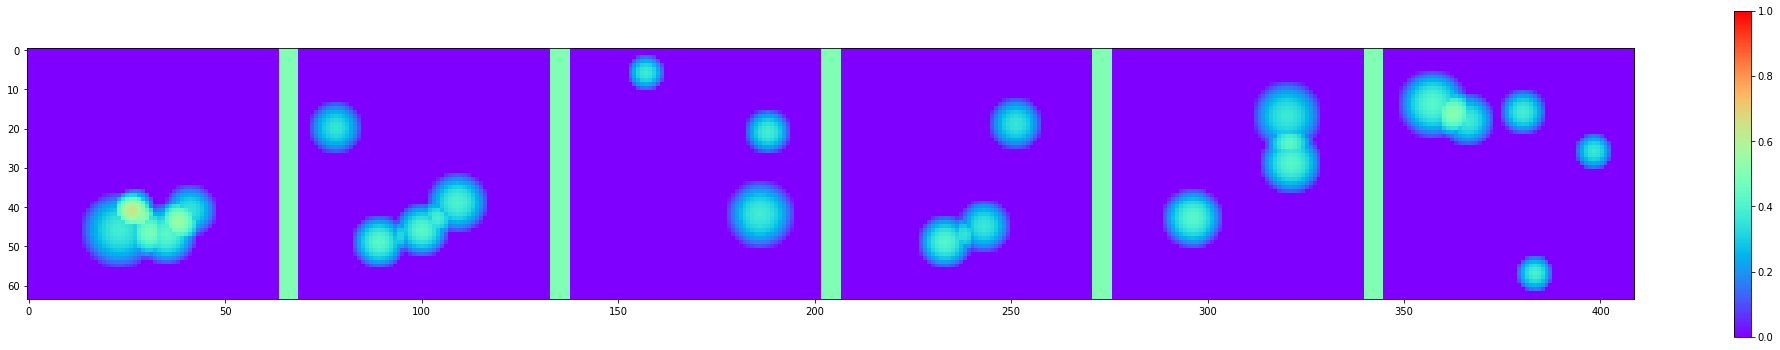

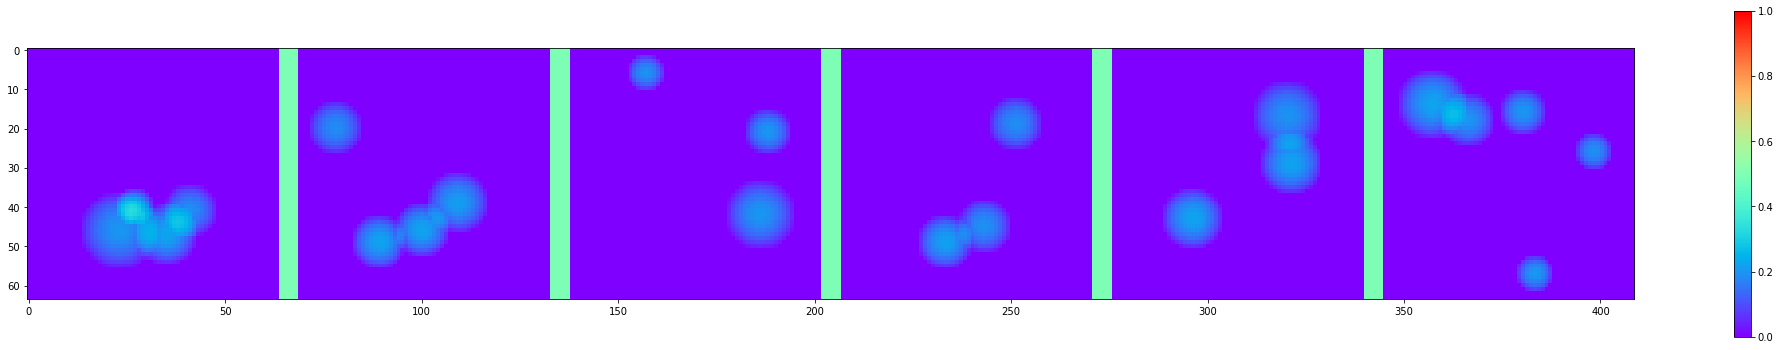

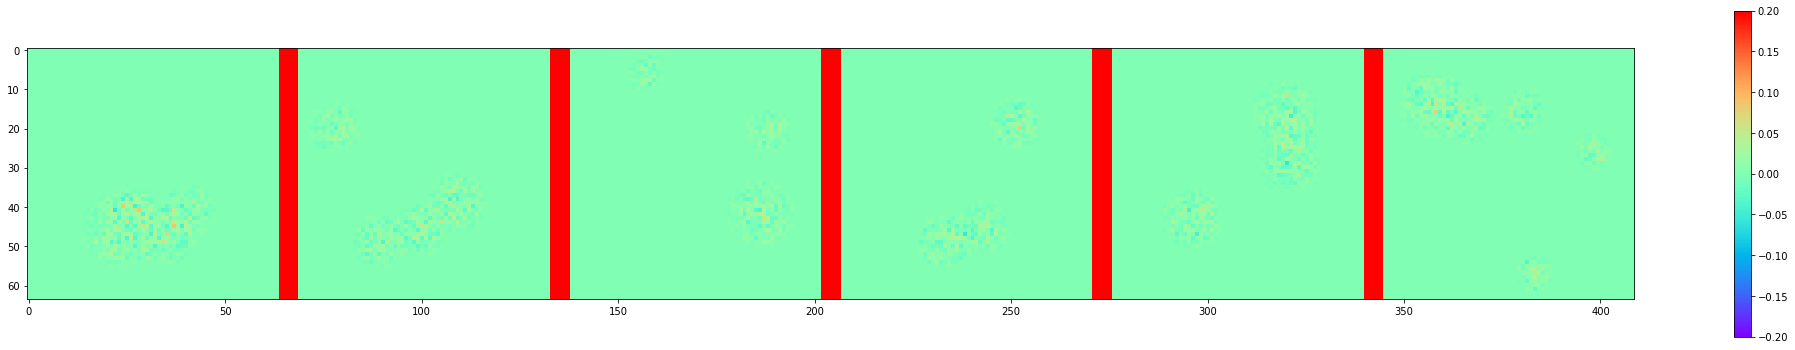

In [ ]:
#visualisation:

fcn.eval()

input, target = gen(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=1)

m = torch.distributions.normal.Normal(input, 0.2*target+0.001, validate_args=None)
quantiles = m.icdf(0*input + 0.9)
fig2 = plt.figure(2, figsize=(36, 6))  #troisième ligne: différence entre 90 centile et sortie
voir_batch2D(output.detach().cpu()[:,[90],:,:] - quantiles, 6, fig2, k=0, min_scale=-0.2,max_scale=0.2)


tensor(0.3088)


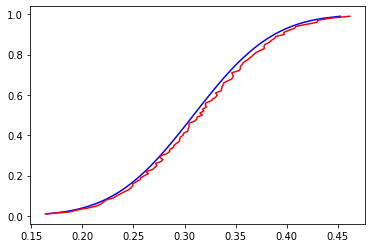

In [ ]:
# plot the CDF estimated on the first image, at pixel (50,25)
pixel = (0,0,50,25)
val = input[pixel]
print(val)
m = torch.distributions.normal.Normal(val, 0.2*val)
x = torch.arange(0.01,1.,0.01)

plt.plot(m.icdf(x), x, color = 'blue')


icdf = output[pixel[0],:,pixel[2],pixel[3]].detach().cpu()

plt.plot(icdf, x, color = 'red')